In [52]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

In [19]:
def gbm_simulator_with_deltas(S0, mu, sigma, n_days=12, n_sequences=50000, annual_trading_days=252):
    sequences = []
    delta_sequences = []
    
    for i in range(n_sequences):
        # Time horizon and time step
        T = n_days / annual_trading_days
        dt = T / n_days
        
        # Time vector
        t = np.linspace(0, T, n_days)
        
        # Generate Wiener process increments
        W_increments = np.random.normal(0, np.sqrt(dt), n_days)
        W = np.cumsum(W_increments)  # Cumulative Wiener process
        
        # Geometric Brownian Motion (GBM) process
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        # Calculate price deltas (differences between consecutive prices)
        Delta_GBM = np.diff(S)  # Price deltas
        
        sequences.append(S)
        delta_sequences.append(Delta_GBM)
    
    return np.array(sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def plot_three_moments(sim_means, real_means, bin_edges_mean,
                       sim_variances, real_variances, bin_edges_var,
                       sim_skew, real_skew, bin_edges_skew):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    # Plot 1: Mean Distribution
    axs[0].hist(sim_means, bins=bin_edges_mean, alpha=0.8, label='Simulated', color='red')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].set_ylim(0,1800)

    # Plot 1: Variance Distribution
    axs[1].hist(sim_variances, bins=bin_edges_var, alpha=0.8, label='Simulated', color='red')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].set_ylim(0,1800)
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(sim_skew, bins=bin_edges_skew, alpha=0.8, label='Simulated', color='red')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].set_ylim(0,1800)
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()  

def plot_sequences(real_seq, sim_seq):
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i][1:], label='Real Trajectory', color='skyblue', linewidth=1.5)
        axes[i].plot(sim_seq[i], label='Generated Trajectory', color='red', linewidth=1.5)
        axes[i].legend(loc='best')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0, 40)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def wasserstein_dist(real_sequences, generated_sequences):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_distances = []
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], generated_sequences[:, t])
        wasserstein_distances.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 7))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(2, 2)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_distances, marker='o')
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    
    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep = np.argmax(wasserstein_distances)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep]
    generated_data = generated_sequences[:, worst_timestep]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Generated', color='orange')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def distribution_evolution(real_sequences, generated_sequences, token_size):

    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histogram for each timestep
    hist_data_real = []
    for t in range(n_timesteps):
        hist, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                     density=True, range=(real_sequences.min(), real_sequences.max()))
        hist_data_real.append(hist)

    hist_data_gen = []
    for t in range(n_timesteps):
        hist, _ = np.histogram(generated_sequences[:, t], bins=bins, 
                                     density=True, range=(generated_sequences.min(), real_sequences.max()))
        hist_data_gen.append(hist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 7))
    gs = plt.GridSpec(2, 2)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(np.array(hist_data_real).T, ax=ax1, cmap='viridis')
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(np.array(hist_data_gen).T, ax=ax2, cmap='viridis')
    ax2.set_title('Generated Sequences Distribution Evolution')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

def calculate_acf(trajectories, nlags):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

def calculate_pacf(trajectories, nlags):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

def plot_acf_pacf(real_sequences, generated_sequences):

    nlags_acf = len(real_sequences[0])-1
    nlags_pacf = int(len(real_sequences[0])/2-2)
    
    # ACFs for real and simulated trajectories
    real_acfs = calculate_acf([real_sequences[i] for i in range(len(real_sequences))], nlags=nlags_acf)
    simulated_acfs = calculate_acf([generated_sequences[i] for i in range(len(generated_sequences))], nlags=nlags_acf)
    avg_real_acf = np.mean(real_acfs, axis=0)
    avg_simulated_acf = np.mean(simulated_acfs, axis=0)

    # Calculate PACFs for real and simulated trajectories
    real_pacfs = calculate_pacf([real_sequences[i][1:] for i in range(len(real_sequences))], nlags=nlags_pacf)
    simulated_pacfs = calculate_pacf([generated_sequences[i] for i in range(len(generated_sequences))], nlags=nlags_pacf)
    avg_real_pacf = np.mean(real_pacfs, axis=0)
    avg_simulated_pacf = np.mean(simulated_pacfs, axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the averaged ACFs
    axs[0].plot(avg_real_acf, label='Real', color='green')
    axs[0].plot(avg_simulated_acf, label='Simulated', color='red')
    axs[0].set_title('Average Autocorrelation Function')
    axs[0].set_xlabel('Lag')
    axs[0].set_ylabel('Autocorrelation')
    #axs[0].set_xticks(np.arange(0, nlags_acf, 1))
    axs[0].legend()

    # Plot the averaged PACFs
    axs[1].plot(avg_real_pacf, label='Real', color='green')
    axs[1].plot(avg_simulated_pacf, label='Simulated', color='red')
    axs[1].set_title('Average Partial Autocorrelation Function')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Partial Autocorrelation')
    #axs[1].set_xticks(np.arange(0, nlags_pacf, 1))
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def calculate_entropy(sequence):
    
    # Get unique values and their counts in one pass
    values, counts = np.unique(sequence, return_counts=True)
    
    # Calculate probabilities using vectorized operation
    probabilities = counts / len(sequence)
    
    # Calculate entropy vectorized with numerical stability
    # Using log(p) directly is stable when p > 0
    entropy = -np.sum(probabilities * np.log(probabilities))
    
    return entropy

def plot_price_hist(price, deltas, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: GBM Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(-5.1, 5.1 + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: GBM Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()

def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_rewards(ep_rew, kl_div, ep_len=None):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')
    #axs[0].set_ylim(-12,0)

    axs[1].plot(ep_len, color='blue')
    axs[1].set_title('Episode Length')
    axs[1].set_ylabel('Length')
    axs[1].set_xlabel('Episode')

    axs[2].plot(kl_div, color='blue')
    axs[2].set_title('KL Div. real vs. sim sequences')
    axs[2].set_ylabel('KL Divergence')
    axs[2].set_xlabel('Model Update')

    plt.show()

def plot_discriminator(wasserstein, disc_acc, disc_loss):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(wasserstein, color='blue')
    axs[0].set_title('Wasserstein Distance')
    axs[0].set_ylabel('WS Distance')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc, color='blue')
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0,1)

    axs[2].plot(disc_loss, color='blue')
    axs[2].set_title('Discriminator Loss')
    axs[2].set_ylabel('Loss')
    axs[2].set_xlabel('Model Update')

    plt.show()


Standard Deviation of Price Deltas: 1.27
BIN WIDTH:  0.3
Number of Tokens: 34
Training Data Shape: (30000, 26)
Validation Data Shape: (10000, 26)
Test Data Shape: (10000, 26)


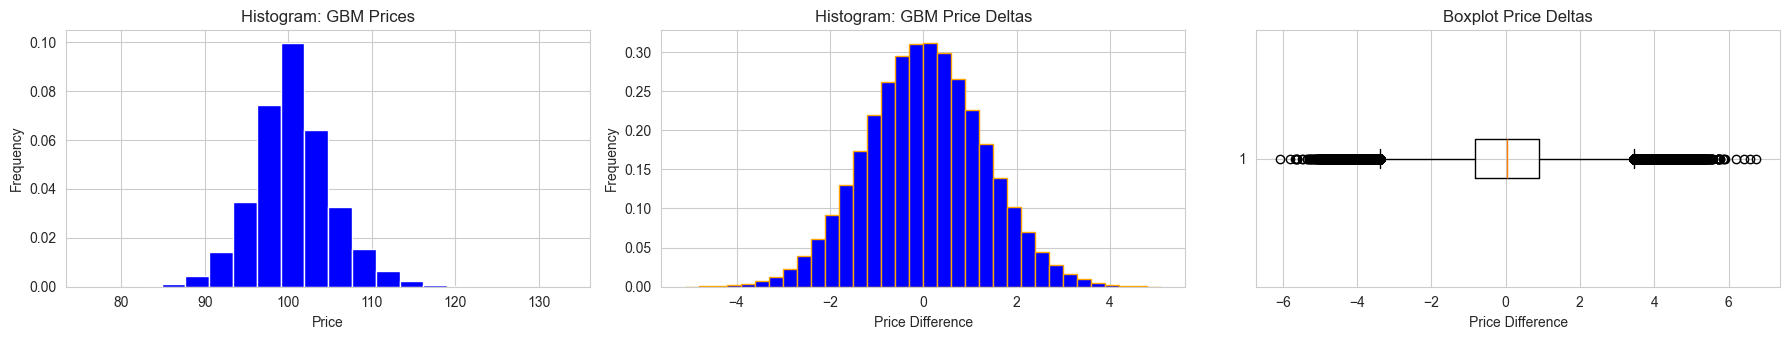

In [4]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 27             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate

Price_GBM, Delta_GBM = gbm_simulator_with_deltas(S0, mu, sigma, n_days=n_days, n_sequences=n_sequences)

bin_width = 0.3
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)

train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-5.1, bin_stop=5.1, bin_width=bin_width)

plot_price_hist(Price_GBM, Delta_GBM, bin_width)


### Supervised Learning

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # LSTM Layer with 2 layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # LSTM Layer (with 2 stacked layers)
        # x shape should be: [batch_size, sequence_length, input_dim]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)      # Shape: [batch_size, sequence_length, hidden_dim]
        
        # Apply Fully Connected Layer to each time step
        logits = self.fc(lstm_out)                       # Shape: [batch_size, sequence_length, output_dim]

        return logits, (h_n, c_n)                        # Return predictions for each time step

In [6]:
hidden_dim = 64                # Hidden Dimension
batch_size = 512                # Batch Size
learning_rate = 0.001           # LR
seq_len = len(train_data[0])    # Length of your tokenized sequences
num_epochs = 10                 # Number of epochs to train

In [7]:
model_supervised = LSTMModel(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    temp_train_loss = []
    temp_val_loss = []
    
    ## ============
    ## TRAINING
    ## ============

    # Shuffle the data at the beginning of the epoch
    indices = np.arange(len(train_data))
    np.random.shuffle(indices)

    for batch_idx in range(0, len(train_data), batch_size):
        model_supervised.train()
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_data[batch_indices]
        
        inputs = th.tensor(batch[:, :-1], dtype=th.float32).unsqueeze(-1)
        targets = th.tensor(batch[:, 1:], dtype=th.long)
        
        # Forward pass for this batch
        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
        targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
        
        loss = criterion_supervised(logits, targets)
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the model parameters
        
        
        temp_train_loss.append(loss.item())
        
        ## ============
        ## VALIDATION
        ## ============

        model_supervised.eval()
        
        with th.no_grad():
            inputs = th.tensor(val_data[:, :-1], dtype=th.float32).unsqueeze(-1)  # All tokens except the last
            targets = th.tensor(val_data[:, 1:], dtype=th.long)  # All tokens except the first
            logits, _ = model_supervised(inputs, None)
            logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
            targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
            loss = criterion_supervised(logits, targets)
            temp_val_loss.append(loss.item())
        
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            th.save(model_supervised.state_dict(), 'supervised_weights.pth')
    
    train_losses.extend(temp_train_loss)
    val_losses.extend(temp_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")

Epoch 1/10 - Train Loss: 3.1086 - Val Loss: 3.0970
Epoch 2/10 - Train Loss: 2.8782 - Val Loss: 2.8786
Epoch 3/10 - Train Loss: 2.8719 - Val Loss: 2.8726
Epoch 4/10 - Train Loss: 2.8696 - Val Loss: 2.8705
Epoch 5/10 - Train Loss: 2.8683 - Val Loss: 2.8694
Epoch 6/10 - Train Loss: 2.8676 - Val Loss: 2.8685
Epoch 7/10 - Train Loss: 2.8669 - Val Loss: 2.8679
Epoch 8/10 - Train Loss: 2.8665 - Val Loss: 2.8674
Epoch 9/10 - Train Loss: 2.8660 - Val Loss: 2.8671
Epoch 10/10 - Train Loss: 2.8658 - Val Loss: 2.8668


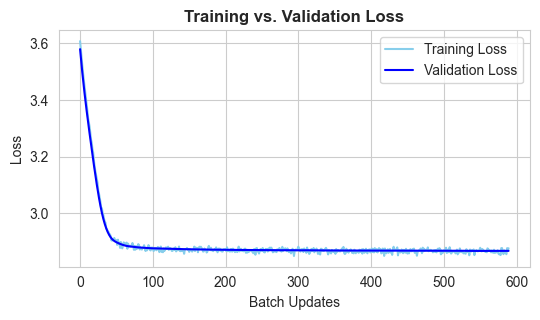

In [8]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_losses, label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', color='blue', linewidth=1.5)
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

In [9]:
inference_model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('supervised_weights.pth', weights_only=False))

val_data_inference = th.tensor(val_data, dtype=th.float32)

test_losses = []
supervised_data = []

inference_model.eval()

with th.no_grad():
    
    for sequence in val_data_inference:

        token_loss = 0

        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]

        hidden = None
        
        for i in range(1, len(sequence)):

            input = sim_trajectory[-1].reshape(1, 1, 1)

            logits, hidden = inference_model(input, hidden)

            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())

            # Loss
            true_token = sequence[i].unsqueeze(-1)

            loss = criterion_supervised(logits.squeeze(1), true_token.long())
            token_loss += loss.item()

        test_losses.append(token_loss/len(sequence))
        supervised_data.append(sim_trajectory[1:])

supervised_data = np.array(supervised_data)

real_means, real_variances, real_std_devs, real_skew, real_kurtosis = calculate_statistics(test_data[:,1:])
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis = calculate_statistics(supervised_data)

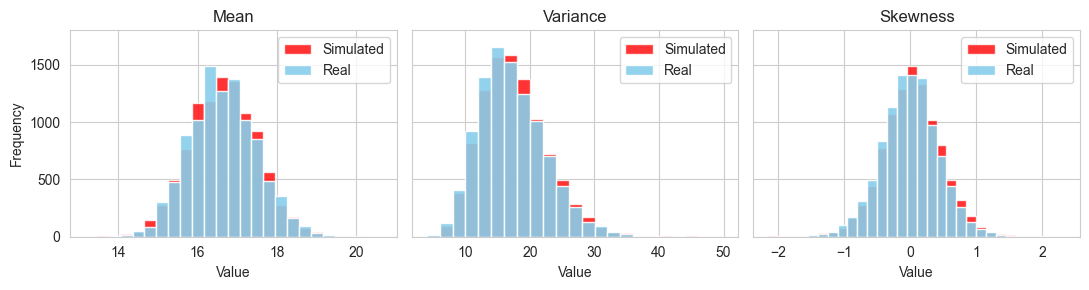

In [10]:
bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))

bin_width_mean = 0.3
bin_width_var = 2
bin_width_skew = 0.15

bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

plot_three_moments(sim_means, real_means, bin_edges_mean,
                       sim_variances, real_variances, bin_edges_var,
                       sim_skew, real_skew, bin_edges_skew)


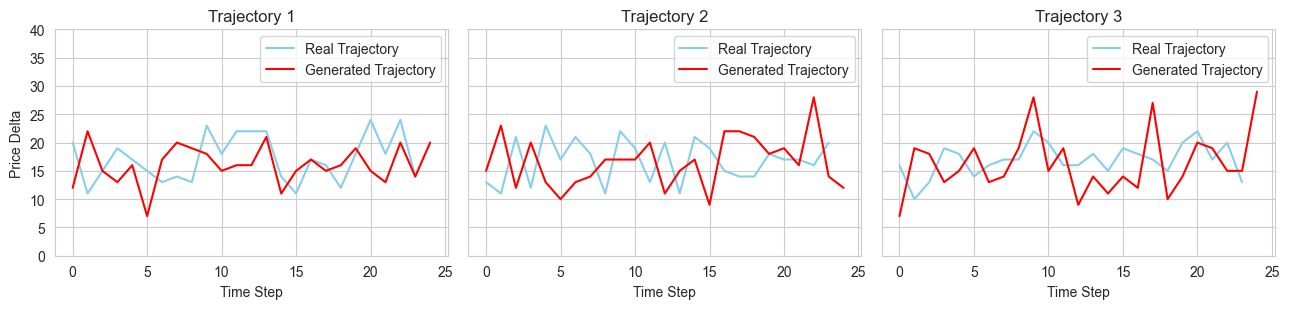

In [11]:
plot_sequences(real_seq=val_data[:,1:], sim_seq=supervised_data)

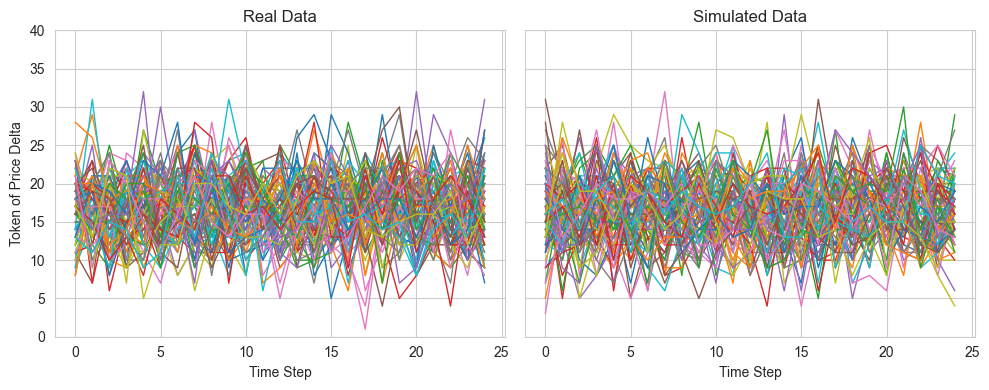

In [12]:
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(100):
    axes[0].plot(val_data[i][1:], linewidth=1)
    axes[1].plot(supervised_data[i], linewidth=1)

axes[0].set_title('Real Data')
axes[0].set_ylim(0, 40)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Token of Price Delta')

axes[1].set_title('Simulated Data')
axes[1].set_ylim(0, 40)
axes[1].set_xlabel('Time Step')
axes[1].tick_params(labelleft=False)

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()

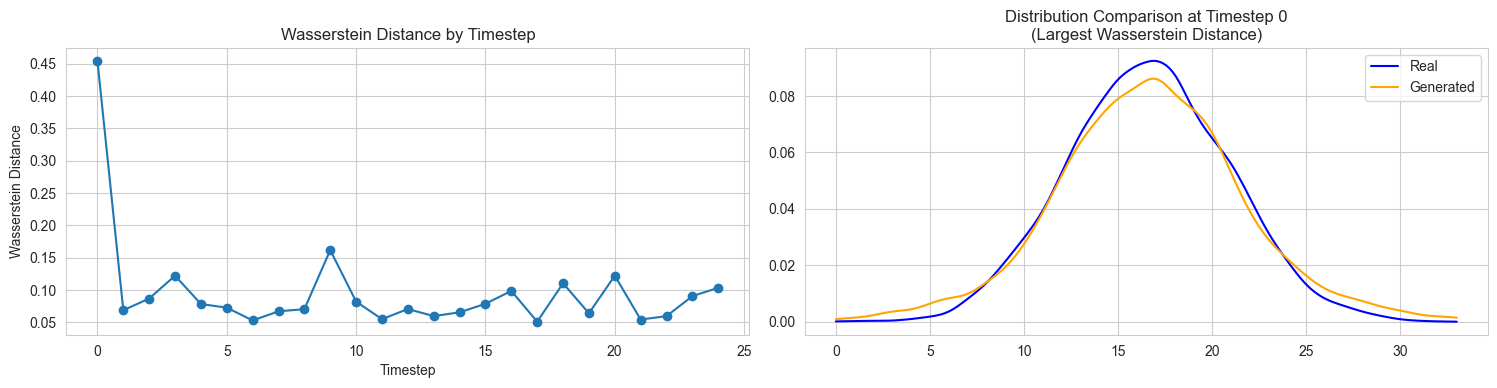

In [13]:
wasserstein_dist(real_sequences=val_data[:,1:], generated_sequences=supervised_data)

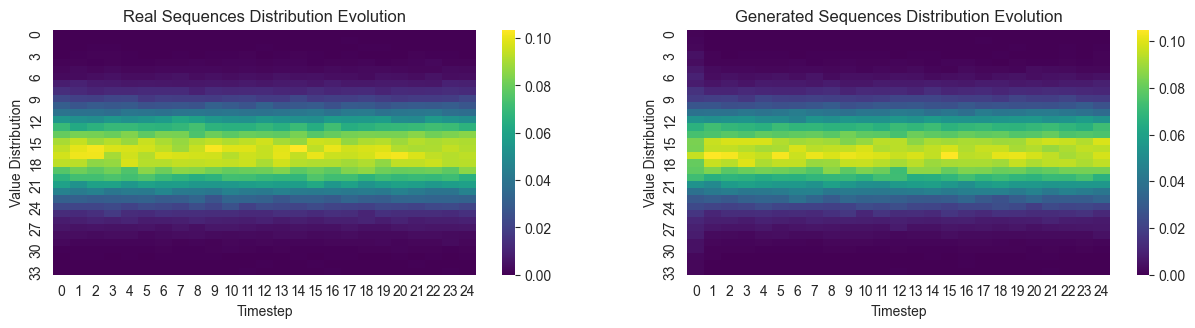

In [14]:
distribution_evolution(real_sequences=val_data[:,1:], generated_sequences=supervised_data, token_size=token_size)

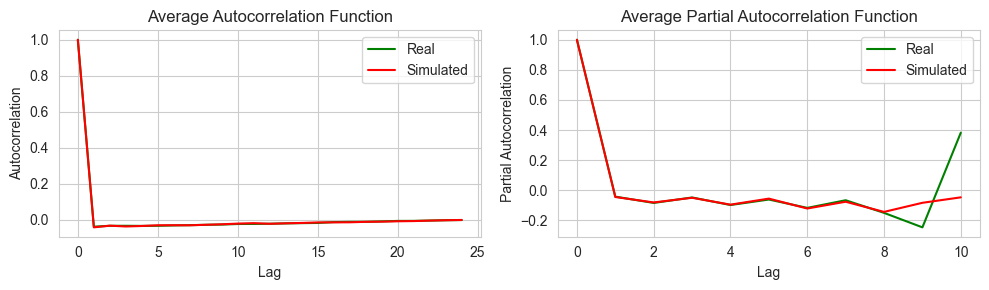

In [15]:
plot_acf_pacf(real_sequences=val_data[:,1:], generated_sequences=supervised_data)

### GAIL

In [ ]:
class LSTM_Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits, hidden

In [ ]:
class CustomEnv(gym.Env):
    
    def __init__(self, train_data, token_size, discriminator, d_optimizer, d_train_auto, d_max_updates):
        
        super(CustomEnv, self).__init__()
        
        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        # Data
        self.train_data = train_data
        
        # Reset
        self.seq_len = None
        self.curr_sim = []
        self.seq_position = 0
        self.hidden_states = None
    
        # Just to compare KL in training
        self.real_train_seq = []
        self.sim_train_seq = []

        # Discriminator
        self.discriminator = discriminator
        self.d_optimizer = d_optimizer
        self.criterion = nn.BCEWithLogitsLoss()

        # Discriminator auto training
        self.d_max_updates = d_max_updates
        self.target_acc_idx = 0

        self.init_disc_train = True

        if d_train_auto:
            self.train_discriminator = self.train_discriminator_new
        else:
            self.train_discriminator = self.train_discriminator_fixed

    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_sim.append(action)

        ###=====REWARD=====###
        reward = self._get_reward(action)
        ###=====REWARD=====###
        
        done = self._is_done()

        if done:            
            self.sim_train_seq.append(self.curr_sim)

        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def reset(self, *, seed = None, options = None):
        
        seq_idx = np.random.choice(len(self.train_data), size = 1).item()
        real_seq = self.train_data[seq_idx]

        self.real_train_seq.append(real_seq[1:])
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_sim = []
        self.seq_position = 0
        self.hidden_states = None
        
        start_token = int(real_seq[0])

        return start_token, {}

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def _get_reward(self, action):

        self.discriminator.eval()

        with th.no_grad():
            temp_action = th.tensor(np.array([[action]]), dtype=th.long)
            prediction, self.hidden_states = self.discriminator(temp_action, self.hidden_states)
            prediction = prediction[0,0]
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            reward = -(seq_loss.item())
            return reward

    def clear_rollout_seq(self):
        self.real_train_seq = []
        self.sim_train_seq = []

    def calculate_kl_div(self):

        real_counts = Counter(np.concatenate(self.real_train_seq))
        fake_counts = Counter(np.concatenate(self.sim_train_seq))
        
        total_real = len(np.concatenate(self.real_train_seq))
        total_fake = len(np.concatenate(self.sim_train_seq))
        
        real_probs = {token: count/total_real for token, count in real_counts.items()}
        fake_probs = {token: count/total_fake for token, count in fake_counts.items()}

        eps = 1e-10  # Small constant for numerical stability
        kl = 0
        for token, p_real in real_probs.items():
            p_fake = fake_probs.get(token, eps)
            if p_real > 0:  # Only compute for non-zero probabilities
                kl += p_real * np.log2(max(p_real, eps) / max(p_fake, eps))
        
        return kl

    def calculate_wasserstein_distance(self):

        real_sequences = np.array(self.real_train_seq)
        generated_sequences = np.array(self.sim_train_seq)
        
        wasserstein_distances = []
        for i in range(len(self.real_train_seq[0])):
            w_dist = wasserstein_distance(real_sequences[:, i], generated_sequences[:, i])
            wasserstein_distances.append(w_dist)

        # Different ways to analyze the results
        return np.mean(wasserstein_distances)  # Overall performance

    def discriminator_accuracy(self, real_data, fake_data):
            
            self.discriminator.eval()

            with th.no_grad():
                
                batch_real = th.tensor(real_data, dtype=th.long)
                batch_fake = th.tensor(fake_data, dtype=th.long)

                # Real data
                real_preds, _ = self.discriminator(batch_real, None)
                real_preds = real_preds[:,-1]
                real_probs = th.sigmoid(real_preds)
                
                # Fake data
                fake_preds, _ = self.discriminator(batch_fake, None)
                fake_preds = fake_preds[:,-1]
                fake_probs = th.sigmoid(fake_preds)

                correct_real = (real_probs > 0.5).float().sum()
                correct_fake = (fake_probs < 0.5).float().sum()
                
                # Total samples
                total_samples = len(real_probs) + len(fake_probs)
                
                # Overall accuracy
                accuracy = (correct_real + correct_fake) / total_samples
            
            return accuracy.item()

    def train_discriminator_fixed(self):

        discriminator_loss = []
        discriminator_accuracy = []
        
        pre_accuracy = self.discriminator_accuracy(np.array(self.real_train_seq), np.array(self.sim_train_seq))
        
        self.discriminator.train()
        
        for _ in range(self.d_max_updates):
            
            # Data Prep
            real_data = np.array(self.real_train_seq)
            fake_data = np.array(self.sim_train_seq)
            indices = th.randperm(len(fake_data))
            batch_real = th.tensor(real_data[indices], dtype=th.long)
            batch_fake = th.tensor(fake_data[indices], dtype=th.long)

            # Real data
            real_preds, _ = self.discriminator(batch_real, None)
            real_preds = real_preds[:,-1]
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)

            # Fake data
            fake_preds, _ = self.discriminator(batch_fake, None)
            fake_preds = fake_preds[:,-1]
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)

            # Loss
            d_loss = (real_loss + fake_loss) / 2

            # Model Update
            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()
            
            # Accuracy
            with th.no_grad():
                 # Convert logits to probabilities using sigmoid
                real_probs = th.sigmoid(real_preds)
                fake_probs = th.sigmoid(fake_preds)
                # Count correct predictions
                correct_real = (real_probs > 0.50).float().sum()
                correct_fake = (fake_probs < 0.50).float().sum()
                # Total samples
                total_samples = len(real_probs) + len(fake_probs)
                # Overall accuracy
                accuracy = (correct_real + correct_fake) / total_samples
            
            discriminator_loss.append(d_loss.item())
            discriminator_accuracy.append(accuracy.item())
        
        post_accuracy = self.discriminator_accuracy(np.array(self.real_train_seq), np.array(self.sim_train_seq))
        
        return discriminator_loss, discriminator_accuracy, pre_accuracy, post_accuracy

    def train_discriminator_auto(self):

        discriminator_loss = []
        discriminator_accuracy = []

        real_sequences = np.array(self.real_train_seq)
        fake_sequences = np.array(self.sim_train_seq)

        pre_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)
        
        n_updates = 0
        
        # target_accuracy_list = [0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.52, 0.5]

        # if self.target_acc_idx < (len(target_accuracy_list)-1):
        #     taget_accuracy = target_accuracy_list[self.target_acc_idx]
        # else:
        #     taget_accuracy = target_accuracy_list[-1]

        if self.init_disc_train:
            taget_accuracy = 0.80
            self.init_disc_train = False
        else:
            if pre_accuracy > 0.7:
                taget_accuracy = pre_accuracy
            elif pre_accuracy > 0.6:
                taget_accuracy = pre_accuracy + 0.04
                print(f"New Target Accuracy: {taget_accuracy:.3f}")
            elif pre_accuracy > 0.5:
                taget_accuracy = pre_accuracy + 0.02
                print(f"New Target Accuracy: {taget_accuracy:.3f}")
            else:
                taget_accuracy = 0.55
                print(f"New Target Accuracy: {taget_accuracy:.3f}")
            
        current_accuracy = pre_accuracy

        while current_accuracy < taget_accuracy:

            #### TRAINING STAGE ####
            self.discriminator.train()
            
            # Get Batch
            real_data = np.array(self.real_train_seq)
            fake_data = np.array(self.sim_train_seq)
            indices = th.randperm(len(fake_data))
            batch_real = th.tensor(real_data[indices], dtype=th.long)
            batch_fake = th.tensor(fake_data[indices], dtype=th.long)
            
            # Real data
            real_preds, _ = self.discriminator(batch_real, None)
            real_preds = real_preds.view(-1)  # Flatten all predictions
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)
            # Fake data
            fake_preds, _ = self.discriminator(batch_fake, None)
            fake_preds = fake_preds.view(-1)  # Flatten all predictions
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)
            # Loss
            d_loss = (real_loss + fake_loss) / 2
            # Model Update
            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()

            # Calculate Accuracy
            #real_sequences, fake_sequences = self.discriminator_batch(training=True)
            current_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)

            discriminator_loss.append(d_loss.item())
            discriminator_accuracy.append(current_accuracy)

            n_updates += 1

            
            
            if n_updates > self.d_max_updates:

                print("Discriminator Overfit")
                
                #self.target_acc_idx += 1
                
                # if self.target_acc_idx < (len(target_accuracy_list)):
                #     taget_accuracy = target_accuracy_list[self.target_acc_idx]
                #     print(f"New Target Accuracy: {taget_accuracy}")

                break
    
        post_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)

        return discriminator_loss, discriminator_accuracy, pre_accuracy, post_accuracy

    def discriminator_loss(self, real_data, fake_data):

        self.discriminator.eval()  # Set to evaluation mode

        with th.no_grad():
            batch_real = th.tensor(real_data, dtype=th.long)
            batch_fake = th.tensor(fake_data, dtype=th.long)
            
            # Real data
            real_preds, _ = self.discriminator(batch_real, None)
            real_preds = real_preds.view(-1)
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)
            
            # Fake data
            fake_preds, _ = self.discriminator(batch_fake, None)
            fake_preds = fake_preds.view(-1)
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)
            
            # Average loss
            d_loss = (real_loss + fake_loss) / 2

            return d_loss
    
    def train_discriminator_new(self):
        discriminator_loss = []
        discriminator_accuracy = []

        # Convert to arrays once at the start
        real_sequences = np.array(self.real_train_seq)
        fake_sequences = np.array(self.sim_train_seq)

        # Get initial metrics
        pre_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)
        discr_loss = self.discriminator_loss(real_sequences, fake_sequences)
        
        # Adaptive updates based on performance
        d_loss_threshold = 0.6
        min_d_updates = 5
        max_d_updates = 10
        d_updates = max_d_updates if discr_loss > d_loss_threshold else min_d_updates

        self.discriminator.train()

        # Calculate batch size - consider adding this
        batch_size = min(128, len(fake_sequences))  # Reasonable batch size

        for _ in range(d_updates):
            # Create mini-batches
            indices = th.randperm(len(fake_sequences))[:batch_size]  # Use only batch_size samples
            batch_real = th.tensor(real_sequences[indices], dtype=th.long)
            batch_fake = th.tensor(fake_sequences[indices], dtype=th.long)
            
            # Forward pass - real data
            real_preds, _ = self.discriminator(batch_real, None)
            real_preds = real_preds.view(-1)
            real_labels = th.ones_like(real_preds) * 0.9  # Label smoothing
            real_loss = self.criterion(real_preds, real_labels)
            
            # Forward pass - fake data
            fake_preds, _ = self.discriminator(batch_fake, None)
            fake_preds = fake_preds.view(-1)
            fake_labels = th.ones_like(fake_preds) * 0.1  # Label smoothing
            fake_loss = self.criterion(fake_preds, fake_labels)
            
            # Combined loss and update
            d_loss = (real_loss + fake_loss) / 2
            self.d_optimizer.zero_grad()
            d_loss.backward()
            th.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)  # Add gradient clipping
            self.d_optimizer.step()
            
            # Track metrics
            with th.no_grad():  # Add no_grad for efficiency
                current_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)
                discriminator_accuracy.append(current_accuracy)
                discriminator_loss.append(d_loss.item())

        post_accuracy = self.discriminator_accuracy(real_sequences, fake_sequences)

        return discriminator_loss, discriminator_accuracy, pre_accuracy, post_accuracy


In [61]:
class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug

    Those variables will be accessible in the callback
    (they are defined in the base class)
    The RL model
    self.model = None  # type: BaseRLModel
    An alias for self.model.get_env(), the environment used for training
    self.training_env = None  # type: Union[gym.Env, VecEnv, None]
    Number of time the callback was called
    self.n_calls = 0  # type: int
    self.num_timesteps = 0  # type: int
    local and global variables
    self.locals = None  # type: Dict[str, Any]
    self.globals = None  # type: Dict[str, Any]
    The logger object, used to report things in the terminal
    self.logger = None  # type: logger.Logger
    # Sometimes, for event callback, it is useful
    # to have access to the parent object
    self.parent = None  # type: Optional[BaseCallback]

    train/learning_rate
    train/entropy_loss
    train/policy_gradient_loss
    train/value_loss
    train/approx_kl
    train/clip_fraction
    train/loss
    train/explained_variance
    train/n_updates
    train/clip_range
    """
    
    def __init__(self, verbose, display_rollout):
        
        super(CustomCallback, self).__init__(verbose)
        
        # Display Rollout
        self.display_rollout = display_rollout
        # Losses
        self.pg_losses, self.value_losses, self.entropy_losses = [], [], []
        # Rewards
        self.rewards = []
        # KL Div
        self.kl_div = []
        # Wasserstein
        self.wasserstein = []
        
        # Discriminator
        self.discriminator_loss = []
        self.discriminator_accuracy = []
        self.d_pre_acc = []
        self.d_post_acc = []

    def _on_training_start(self) -> None:
        
        pass

    def _on_rollout_start(self) -> None:
        
        self.save_losses()

    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:

        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()

        ## NEED TO ADJUST FOR MULTIPLE ENVIRONMENTS
        for env in self.training_env.envs:
            
            # Calculate KL Div.
            curr_kl =  env.unwrapped.calculate_kl_div()

            # Calculate Wasserstein Distance
            wasser_dis = env.unwrapped.calculate_wasserstein_distance()
            
            # Train Discriminator            
            d_train_loss, d_train_acc, pre_accuracy, post_accuracy = env.unwrapped.train_discriminator()
            
            # Reset Lists
            env.unwrapped.clear_rollout_seq()
        
        self.kl_div.append(curr_kl)
        self.wasserstein.append(wasser_dis)
        self.discriminator_loss.extend(d_train_loss)
        self.discriminator_accuracy.extend(d_train_acc)
        self.d_pre_acc.append(pre_accuracy)
        self.d_post_acc.append(post_accuracy)

        print(f"Wasserstein: {self.wasserstein[-1]:.3f} - KL Divergence: {self.kl_div[-1]:.3f} - Pre Accuracy: {self.d_pre_acc[-1]:.3f} - Post Accuracy: {self.d_post_acc[-1]:.3f}")

    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Get original shaped arrays
        observations = self.model.rollout_buffer.observations  # Shape: (n_steps, n_envs)
        actions = self.model.rollout_buffer.actions
        rewards = self.model.rollout_buffer.rewards
        returns = self.model.rollout_buffer.returns
        episode_starts = self.model.rollout_buffer.episode_starts
        values = self.model.rollout_buffer.values
        log_probs = self.model.rollout_buffer.log_probs
        advantages = self.model.rollout_buffer.advantages
        
        # Print header with line
        header = "  env_id    step    observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))
        print(header)
        print("-" * (len(header) + 5))
        
        # For each environment
        for env_idx in range(self.training_env.num_envs):
            # Get data for this environment
            env_obs = observations[:, env_idx]
            env_actions = actions[:, env_idx]
            env_rewards = rewards[:, env_idx]
            env_returns = returns[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            env_values = values[:, env_idx]
            env_log_probs = log_probs[:, env_idx]
            env_advantages = advantages[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            
            # Print rows for this environment
            last_idx = -1
            for step in range(len(env_obs)):
                if step in ep_start_idx:
                    if last_idx != -1:
                        print("=" * (len(header) + 5))
                    print(f"Environment {env_idx} - New Episode")
                    print("-" * (len(header) + 5))
                
                # Convert arrays to strings or get first element if array
                obs_str = str(env_obs[step].item()) if hasattr(env_obs[step], 'item') else str(env_obs[step])
                action_str = str(env_actions[step].item()) if hasattr(env_actions[step], 'item') else str(env_actions[step])
                
                print(
                    f"Obs: {obs_str:8s}  "
                    f"Act: {action_str:4s}  "
                    f"Rew: {env_rewards[step]:6.2f}  "
                    f"Ret: {env_returns[step]:7.2f}  "
                    f"Start: {int(env_starts[step]):1d}  "
                    f"Val: {env_values[step]:6.2f}  "
                    f"LogP: {env_log_probs[step]:8.2f}  "
                    f"Adv: {env_advantages[step]:8.2f}")
                
                last_idx = step
            
            print("=" * (len(header) + 5))
            print(f"End of Environment {env_idx}")
            print("\n")

    def save_reward(self):
        # Get rewards without reshaping
        rewards = self.model.rollout_buffer.rewards  # Shape: (n_steps, n_envs)
        episode_starts = self.model.rollout_buffer.episode_starts
        
        all_sequence_rewards = []
        
        # Process each environment separately
        for env_idx in range(self.training_env.num_envs):
            # Get rewards and episode starts for this environment
            env_rewards = rewards[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            if not env_starts[0]:
                ep_start_idx = np.r_[0, ep_start_idx]
                
            # Calculate rewards for this env's sequences
            sequence_rewards = np.add.reduceat(env_rewards, np.r_[0, ep_start_idx[1:]])
            all_sequence_rewards.extend(sequence_rewards)
        
        # Store average across all envs
        self.rewards.append(np.mean(all_sequence_rewards))



In [79]:
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

In [ ]:
# model_test = RecurrentPPO(

#     policy='MlpLstmPolicy',
    
#     env=env_test,
#     verbose=0,

#     n_steps=500*25,
#     batch_size=5*25,
#     n_epochs=7,

#     gamma=0.99,             # 0.99
#     gae_lambda=0.95,        # 0.95

#     clip_range=0.2,
#     clip_range_vf=None,
#     ent_coef=0.05,
#     vf_coef=0.5,
#     max_grad_norm=0.5,

#     learning_rate=linear_schedule(1e-3)

#     ,
#     policy_kwargs=dict(
#         lstm_hidden_size=64,
#         n_lstm_layers=1,
#         # shared_lstm=True,
#         # enable_critic_lstm=False,
#         net_arch=dict(pi=[], vf=[])
#         )
# )

In [80]:
discriminator = LSTM_Discriminator(vocab_size=token_size, embedding_dim=32, hidden_dim=512)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

env_test = CustomEnv(train_data=train_data, token_size=token_size, 
                     discriminator=discriminator, d_optimizer=d_optimizer,
                     d_train_auto=True, d_max_updates=10
                     )

env_test = Monitor(env_test, filename=None) 

model_test = RecurrentPPO(
    policy='MlpLstmPolicy',
    env=env_test,
    verbose=0,

    # Increase exploration
    ent_coef=0.1,          # Increase from 0.05 to encourage more exploration
    
    # Adjust training stability
    n_steps=1000*25,       # Increase rollout length for better temporal learning
    batch_size=10*25,      # Slightly larger batches
    n_epochs=5,            # Reduce from 7 to prevent overfitting to specific patterns
    
    # Learning rate and value function
    learning_rate=linear_schedule(5e-4),  # Start with lower learning rate
    vf_coef=0.7,          # Increase value function importance
    
    # Same architecture but deeper LSTM
    policy_kwargs=dict(
        lstm_hidden_size=128,  # Increase capacity
        n_lstm_layers=2,       # Add another layer for more complex patterns
        net_arch=dict(pi=[], vf=[])
    )
)

callback_test = CustomCallback(verbose=0, display_rollout=False)

In [81]:
model_test.learn(500000, callback=callback_test)
env_test.close()

Wasserstein: 5.057 - KL Divergence: 0.941 - Pre Accuracy: 0.500 - Post Accuracy: 0.995
Wasserstein: 5.161 - KL Divergence: 0.974 - Pre Accuracy: 0.990 - Post Accuracy: 0.998
Wasserstein: 4.633 - KL Divergence: 0.816 - Pre Accuracy: 0.994 - Post Accuracy: 0.996
Wasserstein: 3.935 - KL Divergence: 0.641 - Pre Accuracy: 0.969 - Post Accuracy: 0.988
Wasserstein: 3.174 - KL Divergence: 0.466 - Pre Accuracy: 0.972 - Post Accuracy: 0.976
Wasserstein: 2.461 - KL Divergence: 0.330 - Pre Accuracy: 0.917 - Post Accuracy: 0.952
Wasserstein: 1.764 - KL Divergence: 0.235 - Pre Accuracy: 0.901 - Post Accuracy: 0.922
Wasserstein: 1.303 - KL Divergence: 0.189 - Pre Accuracy: 0.855 - Post Accuracy: 0.788
Wasserstein: 0.966 - KL Divergence: 0.172 - Pre Accuracy: 0.772 - Post Accuracy: 0.849
Wasserstein: 0.730 - KL Divergence: 0.137 - Pre Accuracy: 0.772 - Post Accuracy: 0.768
Wasserstein: 0.679 - KL Divergence: 0.126 - Pre Accuracy: 0.675 - Post Accuracy: 0.766
Wasserstein: 0.636 - KL Divergence: 0.114 -

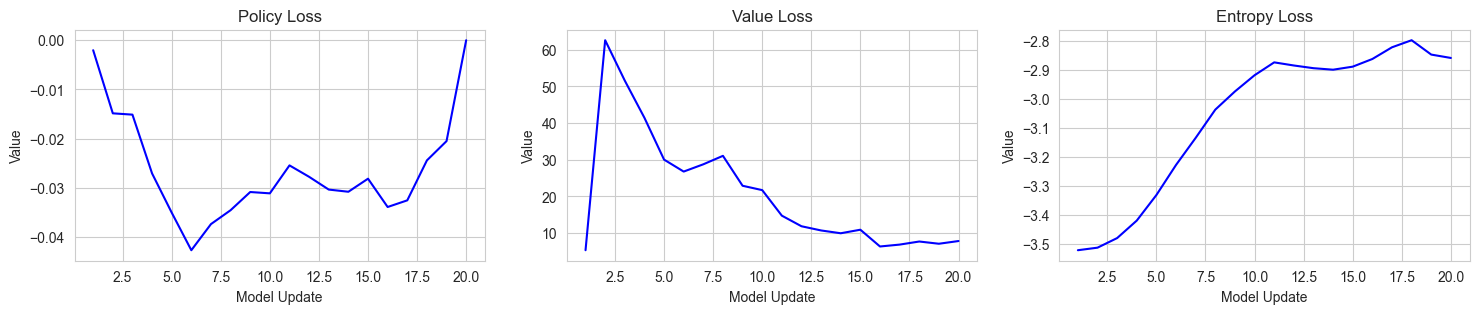

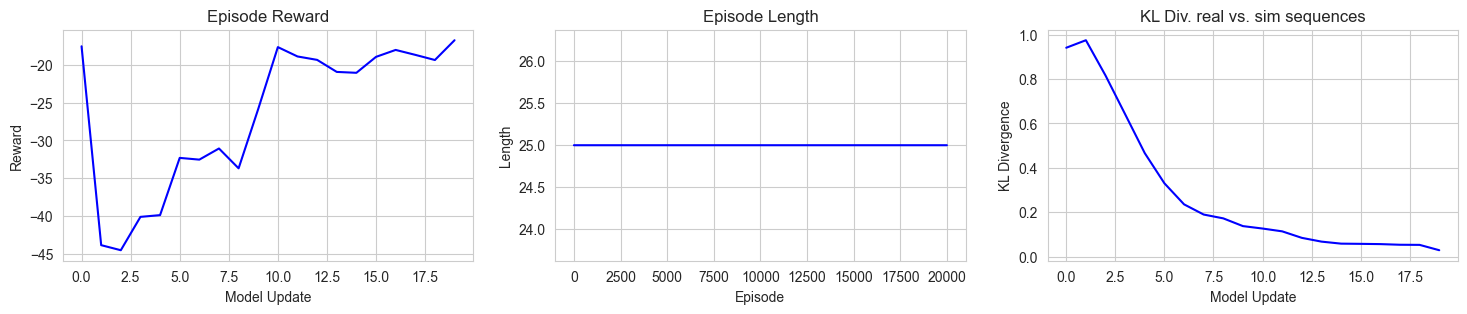

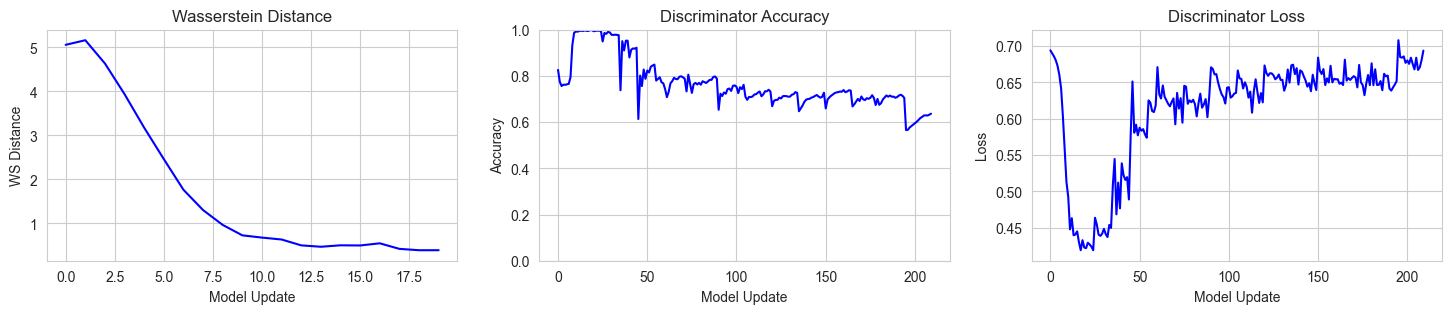

In [82]:
plot_losses(pg_loss=callback_test.pg_losses, 
            value_loss=callback_test.value_losses, 
            entropy_loss=callback_test.entropy_losses)

plot_rewards(ep_rew=callback_test.rewards,
             ep_len=env_test.get_episode_lengths(),
             kl_div=callback_test.kl_div)

plot_discriminator(wasserstein=callback_test.wasserstein, 
                   disc_acc=callback_test.discriminator_accuracy,
                   disc_loss=callback_test.discriminator_loss)

In [83]:
gail_data = []

for sequence in val_data:
    
    _, _ = env_test.reset()
    done = False
    curr_seq_sim  = []
    action = sequence[0]

    lstm_states = None
    num_envs = 1
    episode_starts = np.ones((num_envs,), dtype=bool)

    while not done:
        action, lstm_states = model_test.predict(action, state=lstm_states, episode_start=episode_starts, deterministic=False)
        _, _, done, _, _ = env_test.step(action)
        episode_starts = done
        curr_seq_sim.append(action.item())
    
    gail_data.append(curr_seq_sim)

gail_data = np.array(gail_data)


In [84]:
real_means, real_variances, real_std_devs, real_skew, real_kurtosis = calculate_statistics(val_data[:,1:])
sim_means, sim_variances, sim_std_devs, sim_skew, sim_kurtosis = calculate_statistics(gail_data)

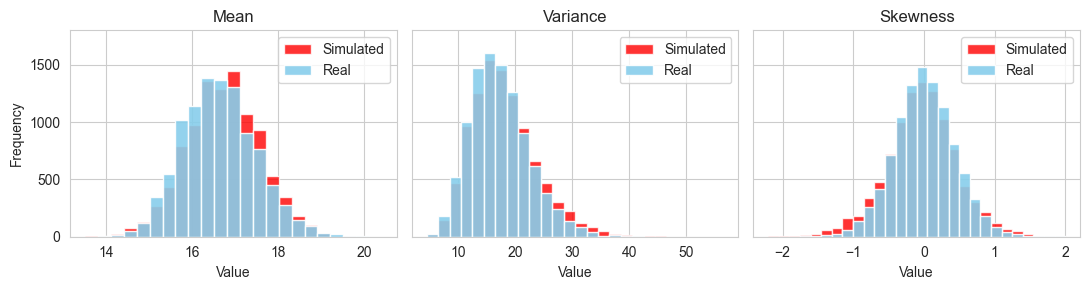

In [85]:
bin_start_mean = min(np.min(sim_means), np.min(real_means))
bin_stop_mean = max(np.max(sim_means), np.max(real_means))
bin_start_var = min(np.min(sim_variances), np.min(real_variances))
bin_stop_var = max(np.max(sim_variances), np.max(real_variances))
bin_start_skew = min(np.min(sim_skew), np.min(real_skew))
bin_stop_skew = max(np.max(sim_skew), np.max(real_skew))

bin_width_mean = 0.3
bin_width_var = 2
bin_width_skew = 0.15

bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

plot_three_moments(sim_means, real_means, bin_edges_mean,
                       sim_variances, real_variances, bin_edges_var,
                       sim_skew, real_skew, bin_edges_skew)

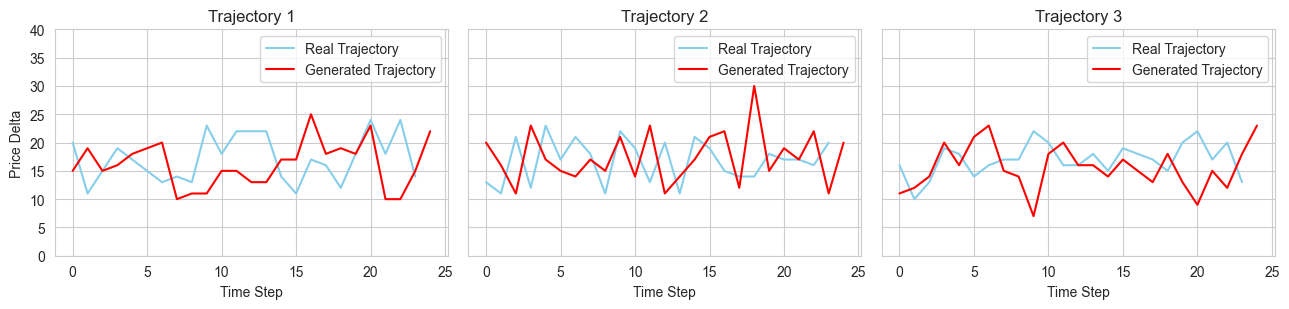

In [86]:
plot_sequences(real_seq=val_data[:,1:], sim_seq=gail_data)

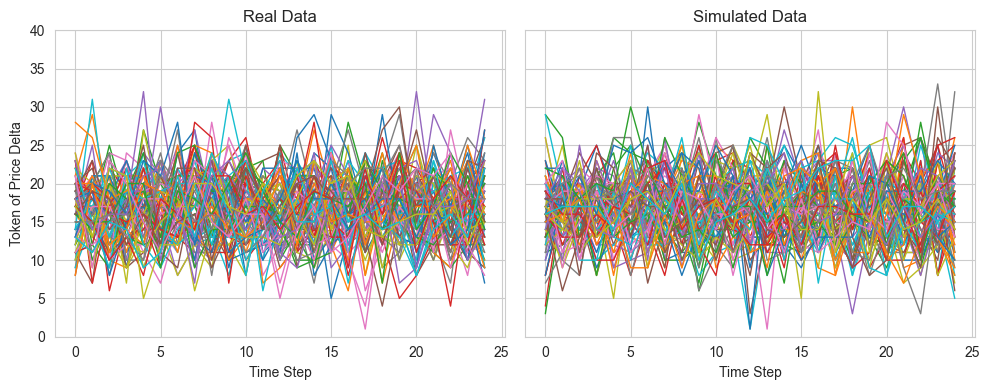

In [87]:
# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(100):
    axes[0].plot(val_data[i][1:], linewidth=1)
    axes[1].plot(gail_data[i], linewidth=1)

axes[0].set_title('Real Data')
axes[0].set_ylim(0, 40)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Token of Price Delta')

axes[1].set_title('Simulated Data')
axes[1].set_ylim(0, 40)
axes[1].set_xlabel('Time Step')
axes[1].tick_params(labelleft=False)

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()

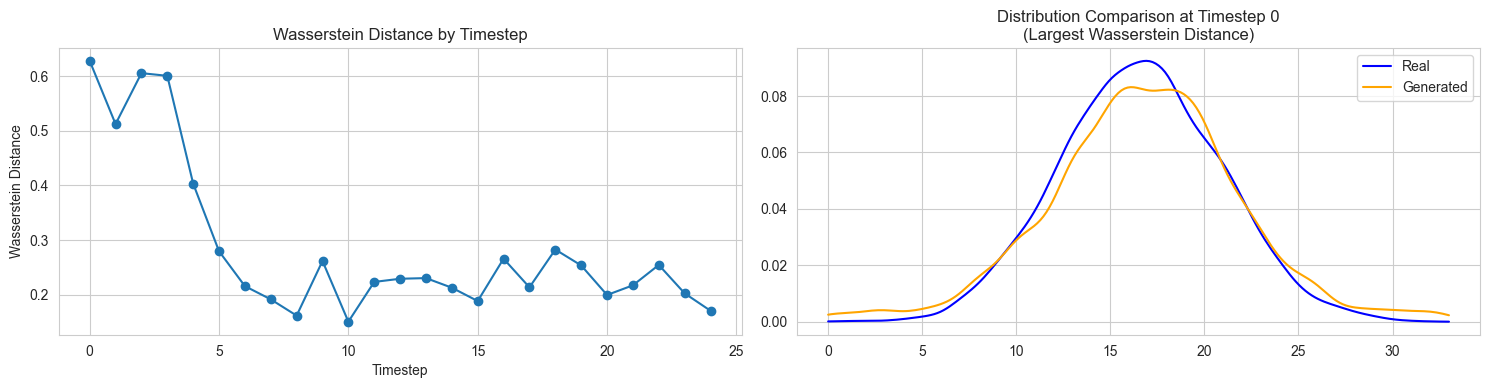

In [88]:
wasserstein_dist(real_sequences=val_data[:,1:], generated_sequences=gail_data)

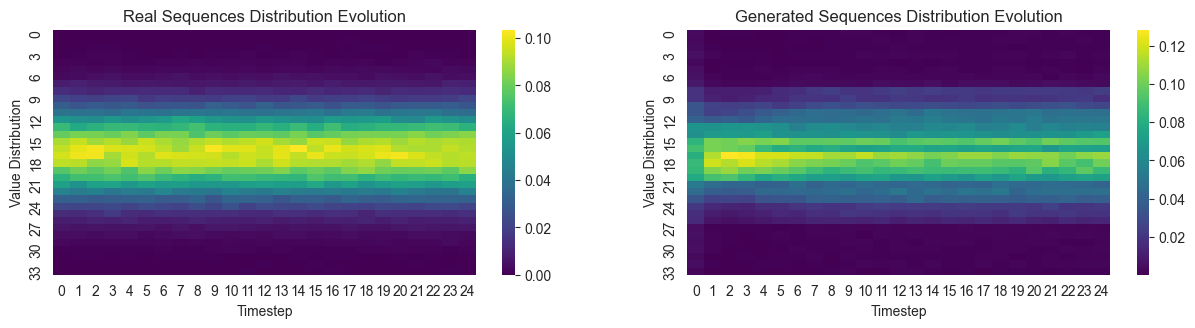

In [89]:
distribution_evolution(real_sequences=val_data[:,1:], generated_sequences=gail_data, token_size=token_size)